<a href="https://colab.research.google.com/github/stoiver/Tohoku/blob/master/notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tohoku Notebook

These notebooks have been designed to run in the google `colaboratory` environment, which provides a jupyter notebook environment running on a virtual machine on the cloud. To use this environment you need a google account so that your notebook can be saved on google drive. 

To start interacting with the notebook follow the 
`View in Colaboratory` link above. 

## Setup Environment

If on github, first follow the link `View in Colaboratory' to start running on google's colab environment. 

### Then ....

Run the following cell to install the dependencies and some extra code for visualising on Colaboratory.
Wait until you see the comment *(6) Ready to go* before proceeding to subsequent commands. 

The install should take less than a minute (and quicker if you have already run this earlier).

In [0]:
try:
  # On colab we can install all the packages we need via the notebook
  #
  # First download the clinic repository
  import os
  os.chdir('/content')
  
  print "(1) Install netcdf nose via pip"
  !pip -q install netCDF4 nose > /dev/null 2>&1 

  print "(2) Install gdal via apt-get"
  !apt-get -q -y install python-gdal gdal-bin > /dev/null 2>&1 

  print "(3) Download anuga_core github repository"
  !git clone -b tsunami_okada  https://github.com/stoiver/anuga_core.git  > /dev/null 2>&1 

  print "(4) Install anuga"
  os.chdir('/content/anuga_core')
  !python setup.py --quiet install  > /dev/null 2>&1 
  os.chdir('..')
  
  print "(5) Download Tohoku github repository"
  !git clone https://github.com/stoiver/Tohoku.git  > /dev/null 2>&1   
  
  print "(6) Ready to go"
 
except:
  pass

### Setup inline graphics and animation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from google.colab import files

%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

## Tohoku Folder

Change into the Tohoku folder

In [0]:
os.chdir('Tohoku')

In [2]:
pwd

u'C:\\Users\\stoiv\\Tohoku'

## Create Domain

In [3]:
import anuga


# Create domain
dx = dy = 1000
L = 80000
W = 80000


# Create topography
def topography(x, y):
    el = -1000
    return el


domain = anuga.rectangular_cross_domain(int(L/dx), int(W/dy), len1=L, len2=W)

domain.set_name('test')
domain.set_quantity('elevation', function=topography, location='centroids')

## Apply Okada to Stage

In [20]:
import anuga.tsunami_source.okada_tsunami_fortran as okada_tsunami_fortran
class Okada_func:

   def __init__(self, source,verbose=False,alp=0.5,dmax=-1.):
      self.elon  = source[:,0]
      self.elat  = source[:,1]
      self.edep  = source[:,2]
      self.strk  = source[:,3]
      self.dip   = source[:,4]
      self.lnt = source[:,5]
      self.wdt = source[:,6]
      self.disl1 = source[:,7]
      self.disl2 = source[:,8]
      self.alp     = alp
      self.dmax    = dmax
      self.verbose = verbose
     
      #print self.elon, self.elat, self.edep, self.strk, self.dip, self.lnt, self.wdt, self.disl1, self.disl2, self.alp, self.dmax, self.verbose
 
   def __call__(self, x, y):
      """Make Okada_func a callable object.
      
      If called as a function, this object returns z values representing
      the initial distribution of water heights at the points (x,y)
      produced by a submarine mass failure.
      """
       
      edsp,ndsp,zdsp = okada_tsunami_fortran.fault_disp(self.alp,self.elon,self.elat,self.edep,self.strk,self.dip,\
                                             self.lnt,self.wdt,self.disl1,self.disl2,x,y,self.dmax)
      return zdsp

[[4.0e+04 4.0e+04 1.5e+01 0.0e+00 1.5e+01 2.0e+01 6.0e+00 1.0e+01 9.0e+01
  0.0e+00]]
2 [0.18104733]
Figure files for each frame will be stored in _plot
7.031578638664829 -2.9324914953107477
-1000.0 -1000.0
1007.0315786386649 997.0675085046893


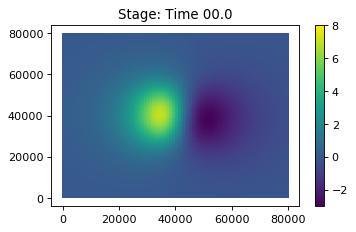

In [24]:
#from anuga.tsunami_source.okada_tsunami import earthquake_source, Okada_func
#from anuga.tsunami_source.tsunami_okada import earthquake_tsunami,Okada_func

x0 = 40000.0
y0 = 40000.0
depth = 15.0
strike = 0.0
dip = 15.0
length = 20.0
width = 6.0
slip = 10.0
rake = 90.0
dis3 = 0.0
NSMAX = 1

ns = 1

source1 = np.array([x0, y0, depth, strike, dip, length, width,
                  slip, rake, dis3]).reshape((1,-1))

print source1
zrec0 = anuga.Quantity(domain)
zrec0.set_values(0.0)
zrec=zrec0.get_vertex_values(xy=True)

Ts = Okada_func(source=source1, verbose=True)


domain.set_quantity('stage', function=Ts, location='centroids') 

print 2, Ts(2000.0, 30000.0)

dplotter = anuga.Domain_plotter(domain)

print np.max(dplotter.stage), np.min(dplotter.stage)
print np.max(dplotter.elev), np.min(dplotter.elev)
print np.max(dplotter.depth), np.min(dplotter.depth)

dplotter.plot_stage_frame(vmin=-3.0, vmax=8.0)

In [0]:
# Initial condition of earthquake for multiple source

x0 = [40000.0, 40000.0]
y0 = [45000.0, 35000.0]
depth = [15.0, 15.0]
strike = [0.0, 0.0]
dip = [15.0, 15.0]
length = [10.0, 10.0]
width = [6.0, 6.0]
slip = [10.0, 10.0]
rake = [90.0, 90.0]
dis3 = [0.0, 0.0]

ns = 2


source2 = np.array([x0, y0, depth, strike, dip, length, width,
                  slip, rake, dis3]).transpose()


Ts = earthquake_source(
             source=source2,
             domain=domain,
             lon_lat_degrees=False,
             lon_before_lat=True,
             utm_zone=None,
             verbose=False)

domain.set_quantity('stage', function=Ts, location='centroids')


print np.max(dplotter.stage), np.min(dplotter.stage)
print np.max(dplotter.elev), np.min(dplotter.elev)
print np.max(dplotter.depth), np.min(dplotter.depth)

dplotter.plot_stage_frame(vmin=-3.0, vmax=8.0)